In [2]:
import importlib

import pandas as pd
from IPython.display import display

import warnings

import Semantic_Maningfullness

warnings.filterwarnings('ignore')

from carla.data.causal_model import CausalModel

In [3]:
import numpy as np 
import torch
import random

#SEED Setting
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [4]:
import pandas as pd


# generate data
scm = CausalModel("sanity-3-lin")
dataset = scm.generate_dataset(10000, False)

# save data
# dataset.df.to_csv('generate_dataset.csv')

display(dataset.df)

fuzzy False


label        x1        x2        x3
0       1.0 -3.822251  3.206103  1.394095
1       0.0 -0.125186 -0.267489 -0.065593
2       0.0  1.388819 -2.420645  0.119093
3       0.0 -0.173873 -0.715379 -1.201855
4       1.0 -0.637307  1.071684  0.379442
...     ...       ...       ...       ...
9995    0.0  0.971876 -0.067054 -1.317657
9996    1.0  1.792395 -2.272653  0.620624
9997    0.0  1.994518 -3.212899 -0.900646
9998    0.0 -2.854051  3.213437 -0.361817
9999    0.0 -2.368446  1.890917 -0.205989

[10000 rows x 4 columns]

In [5]:
# Check Fraction of noisy labels 

def get_classification_from_scm(data, threshold=0.5): 
    #TODO Recheck Calculation 
    label=[]
    for d in data.iterrows():
        d=d[1]
        d=d.drop('label')

        # fix a hyperplane
        w = np.ones((3, 1))
        # get the average scale of (w^T)*X, this depends on the scale of the data
        #print(d)
        #print(d.shape)
        scale = 2.5 / np.mean(np.abs(np.dot(d, w)))
        predictions = 1 / (1 + np.exp(-scale * np.dot(d, w)))
        #predictions=value[0]
        uniform_rv = threshold
        labels = int(uniform_rv < predictions)     
        label.append(labels)

    return label

orig_lab= get_classification_from_scm(dataset.df)
#print(orig_lab)
#print(dataset.df['label'])
noisyLabel=np.count_nonzero(dataset.df['label']-orig_lab)
noisyLabel/len(dataset.df)

0.0

In [5]:
%%script false --no-raise-error
#  Check if Original (non fuzzy) Calc and Output Model would result in identicall predicitons
#THIS CELL Is Currently not excecuted
data= dataset.df
diff=0
for d in data.iterrows():
    d=d[1]
    d=d.drop('label')
    # ORIGINAL CALC
    w = np.ones((3, 1))
    scale = 2.5 / np.mean(np.abs(np.dot(d, w)))
    predictions = 1 / (1 + np.exp(-scale * np.dot(d, w)))
    # Calc in Output Model SCM 
    print(d.to_numpy())
    print([round(d['x1'],8),round(d['x2'],8),round(d['x3'],8)])

    #scale = 
    pred_scM= 1 / (1 + np.exp(-(2.5 / np.mean(np.abs(np.dot([round(d['x1'],8),round(d['x2'],8),round(d['x3'],8)], np.ones((3, 1)))))) * np.dot([round(d['x1'],8),round(d['x2'],8),round(d['x3'],8)], np.ones((3, 1)))))
    #pred_scM= 1/ (1 + np.exp(- 2.5 / np.mean(np.abs(np.dot([round(d['x1'],8),round(d['x2'],8),round(d['x3'],8)], np.ones((3, 1))))))* np.dot([round(d['x1'],8),round(d['x2'],8),round(d['x3'],8)], np.ones((3, 1))))

    print('1', predictions)
    print('2', pred_scM)


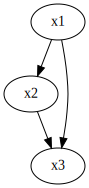

In [6]:
#Visualize the model
scm.cgm.draw()

In [7]:
from carla.models.catalog import MLModelCatalog

training_params = {"lr": 0.01, "epochs": 10, "batch_size": 16, "hidden_size": [18, 9, 3]}

ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
)
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)



balance on test set 0.5169333333333334, balance on test set 0.5152
Epoch 0/9
----------
train Loss: 0.0725 Acc: 0.9716

test Loss: 0.0608 Acc: 0.9776

Epoch 1/9
----------
train Loss: 0.0371 Acc: 0.9853

test Loss: 0.0255 Acc: 0.9888

Epoch 2/9
----------
train Loss: 0.0342 Acc: 0.9872

test Loss: 0.0268 Acc: 0.9868

Epoch 3/9
----------
train Loss: 0.0322 Acc: 0.9869

test Loss: 0.0276 Acc: 0.9884

Epoch 4/9
----------
train Loss: 0.0299 Acc: 0.9888

test Loss: 0.0201 Acc: 0.9912

Epoch 5/9
----------
train Loss: 0.0285 Acc: 0.9891

test Loss: 0.0188 Acc: 0.9920

Epoch 6/9
----------
train Loss: 0.0271 Acc: 0.9897

test Loss: 0.0162 Acc: 0.9928

Epoch 7/9
----------
train Loss: 0.0279 Acc: 0.9897

test Loss: 0.0192 Acc: 0.9928

Epoch 8/9
----------
train Loss: 0.0267 Acc: 0.9895

test Loss: 0.0474 Acc: 0.9816

Epoch 9/9
----------
train Loss: 0.0241 Acc: 0.9899

test Loss: 0.0591 Acc: 0.9756



In [8]:
from carla.models.negative_instances import predict_negative_instances
# get factuals
factuals = predict_negative_instances(ml_model, dataset.df)
test_factual_with_labels = factuals.iloc[:10].reset_index(drop=True)
test_factual=test_factual_with_labels.copy()

print(test_factual)

   label        x1        x2        x3
0    0.0 -0.125186 -0.267489 -0.065593
1    0.0  1.388819 -2.420645  0.119093
2    0.0 -0.173873 -0.715379 -1.201855
3    0.0 -2.087104  2.218720 -0.248939
4    0.0 -1.895168  2.386755 -0.718443
5    0.0  0.721627 -0.507613 -0.951930
6    0.0 -1.589644 -0.152073 -0.688441
7    0.0  1.564789 -2.419099 -1.798075
8    0.0  0.787910 -1.019286 -0.083949
9    0.0 -2.413814  1.743723 -0.176813


In [9]:
from carla.recourse_methods.catalog.causal_recourse import (
    CausalRecourse,
    constraints,
    samplers,
)
hyperparams = {
    "optimization_approach": "brute_force",
    "num_samples": 10,
    "scm": scm,
    "constraint_handle": constraints.point_constraint,
    "sampler_handle": samplers.sample_true_m0,
}

print(len(test_factual))
# structural counterfactual (SCF)
cfs = CausalRecourse(ml_model, hyperparams).get_counterfactuals(test_factual)
print(len(cfs))
output = cfs.reset_index(drop=True) - test_factual.loc[:,~test_factual.columns.isin(['label'])].reset_index(drop=True)
display(output)
display(cfs)

10
FACTUAL INSTANCE NO 0
Action Set {'x1': -12.88998, 'x2': -13.71963, 'x3': -9.56649}
Original x1   -0.125186
x2   -0.267489
x3   -0.065593
Name: 0, dtype: float64
cf Inatance from Constraint          x1        x2       x3
0 -12.88998 -13.71963 -9.56649
prediction from DL Model [[0.]]
Returns [[False]]
Action Set {'x1': -12.88998, 'x2': -13.71963, 'x3': -7.48263}
Original x1   -0.125186
x2   -0.267489
x3   -0.065593
Name: 0, dtype: float64
cf Inatance from Constraint          x1        x2       x3
0 -12.88998 -13.71963 -7.48263
prediction from DL Model [[0.]]
Returns [[False]]
Action Set {'x1': -12.88998, 'x2': -13.71963, 'x3': -5.39877}
Original x1   -0.125186
x2   -0.267489
x3   -0.065593
Name: 0, dtype: float64
cf Inatance from Constraint          x1        x2       x3
0 -12.88998 -13.71963 -5.39877
prediction from DL Model [[0.]]
Returns [[False]]
Action Set {'x1': -12.88998, 'x2': -13.71963, 'x3': -3.31491}
Original x1   -0.125186
x2   -0.267489
x3   -0.065593
Name: 0, dtype: flo

x1      x2       x3
0  0.00000  0.0000  0.85281
1  0.00000 -1.0184  0.00000
2  0.00000  2.1569  0.00000
3  0.00000  0.0000  0.85281
4 -0.52572  2.1569  0.00000
5  0.00000  2.1569  0.00000
6  0.00000  2.1569  0.00000
7  4.41998 -1.0184  0.00000
8  0.00000  0.0000  0.85281
9  0.00000  0.0000  0.85281

x3        x1        x2
0  0.787217 -0.125186 -0.267489
1  0.119093  1.388819 -3.439045
2 -1.201855 -0.173873  1.441521
3  0.603871 -2.087104  2.218720
4 -0.718443 -2.420888  4.543655
5 -0.951930  0.721627  1.649287
6 -0.688441 -1.589644  2.004827
7 -1.798075  5.984769 -3.437499
8  0.768861  0.787910 -1.019286
9  0.675997 -2.413814  1.743723

In [10]:
#SCM with Output Layer. 
#THIS IS ALREADY ADDED TO CARLA; ONLY HERE FOR COMPLETENESS / EASE OF UNDERSTANDING;  BELOW THE CARLA VERSION IS USED.
from carla.data.load_scm.distributions import Bernoulli, MixtureOfGaussians, Normal,Uniform, Bernoulli, Gamma

def sanity_3_lin_output():
    structural_equations_np = {
        "x1": lambda n_samples: n_samples,
        "x2": lambda n_samples, x1: -x1 + n_samples,
        "x3": lambda n_samples, x1, x2: 0.5 * (0.1 * x1 + 0.5 * x2) + n_samples,
        "x4":lambda n_samples, x1, x2,x3: 1/ (1 + np.exp(- 2.5 / np.mean(np.abs(np.dot([x1,x2,x3], np.ones((3, 1))))))* np.dot([x1,x2,x3], np.ones((3, 1))))
    }
    structural_equations_ts = structural_equations_np
    noises_distributions = {
        "u1": MixtureOfGaussians([0.5, 0.5], [-2, +1], [1.5, 1]),
        "u2": Normal(0, 1),
        "u3": Normal(0, 1),
        "u4": Normal(0, 1),
    }
    continuous = list(structural_equations_np.keys()) + list(
        noises_distributions.keys()
    )
    categorical = []
    immutables = []

    return (
        structural_equations_np,
        structural_equations_ts,
        noises_distributions,
        continuous,
        categorical,
        immutables,
    )


In [11]:
scm_output=CausalModel("sanity-3-lin-output")

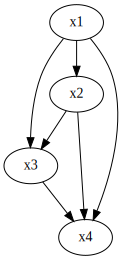

In [12]:
#Visualize the model
scm_output.cgm.draw()

In [13]:
import importlib
from Semantic_Maningfullness import Sematic
importlib.reload(Semantic_Maningfullness)

mapping_dict={ 
      'u1': 'x1',
      'u2': 'x2',
    'u3': 'x3',
      }
results=[]
i=0
#scm_output= sanity_3_lin_output()

test_factual = test_factual.loc[:,~test_factual.columns.isin(['label'])]

for a in test_factual.index:

    if str(cfs.iloc[i]['x1'])=='nan':
        pass
    else:
        sem=Sematic(ml_model,scm_output,mapping_dict)
        
        res=sem.get_evaluation(test_factual.iloc[a],cfs.iloc[i])['semantic'][0]
        results.append( res)
    i=i+1


cflabel from DL model [[0.9999919]]
factuals_label from DL model [[0.00064065]]
Round [[1.]]
probability [0.92414182]
cflabel from DL model [[1.1982997e-09]]
factuals_label from DL model [[1.8304552e-05]]
Round [[0.]]
probability [0.07585818]
cflabel from DL model [[0.36500242]]
factuals_label from DL model [[6.466611e-10]]
Round [[0.]]
probability [0.92414182]
cflabel from DL model [[1.]]
factuals_label from DL model [[0.00369324]]
Round [[1.]]
probability [0.92414182]
cflabel from DL model [[1.]]
factuals_label from DL model [[0.00157707]]
Round [[1.]]
probability [0.92414182]
cflabel from DL model [[1.]]
factuals_label from DL model [[5.5453645e-05]]
Round [[1.]]
probability [0.92414182]
cflabel from DL model [[0.00156304]]
factuals_label from DL model [[1.5157911e-11]]
Round [[0.]]
probability [0.07585818]
cflabel from DL model [[0.9999999]]
factuals_label from DL model [[4.900728e-12]]
Round [[1.]]
probability [0.92414182]
cflabel from DL model [[0.99999976]]
factuals_label from D

In [14]:
from sklearn.metrics import precision_recall_fscore_support,classification_report
from Semantic_Maningfullness import get_pred_from_causal_v2

# Model Accuracy for the above used CF and original test data 
original_test_x = test_factual_with_labels.drop(columns=['label'])
original_test_y = test_factual_with_labels['label']
original_test_y_pred= ml_model.predict(np.array(original_test_x.values).reshape(-1, original_test_x.values.shape[-1]))
original_test_y_pred[np.argwhere(original_test_y_pred>0.5)]=1
original_test_y_pred[np.argwhere(original_test_y_pred<=0.5)]=0
original_test_scm_y_pred=[]
for i,item in original_test_x.iterrows():
    original_test_scm_y_pred.append(get_pred_from_causal_v2(scm_output, item, None, None, 0.5))

# TODO  THIS IS CUTRRENTLY AN ASSUMPTION AS Recourse is only binary 
cf_test_x= cfs.iloc[test_factual.index]
cf_test_y=np.zeros_like(original_test_y)
cf_test_y_pred=  ml_model.predict(np.array(cf_test_x.values).reshape(-1, cf_test_x.values.shape[-1]))
cf_test_y_pred[np.argwhere(cf_test_y_pred>0.5)]=1
cf_test_y_pred[np.argwhere(cf_test_y_pred<=0.5)]=0
for i, x in enumerate(original_test_y):
    if x== 0:
        cf_test_y[i]=1

cf_test_scm_y_pred=[]
for i,item in cf_test_x.iterrows():
    cf_test_scm_y_pred.append(get_pred_from_causal_v2(scm_output, item, None, None, 0.5))


'''CF Consistency with DL Model'''
print('CF Consistency with DL Model')
cf_metrics= classification_report(cf_test_y,cf_test_y_pred.reshape(-1))
print(cf_metrics)
'''CF Consistency with SCM Model'''
print('CF Consistency with SCM Model')
cf_scm_metrics= classification_report(cf_test_y,cf_test_scm_y_pred)
print(cf_scm_metrics)
'''Factual Consistency with DL Model '''
print('Factual Consistency with DL Model ')
factual_metrics= classification_report(original_test_y ,original_test_y_pred.reshape(-1))
print(factual_metrics)
'''Factual Consistency with SXM Model '''
print('Factual Consistency with SXM Model ')
factual_scm_metrics= classification_report(original_test_y ,original_test_scm_y_pred)
print(factual_scm_metrics)

probability [0.07585818]
probability [0.07585818]
probability [0.07585818]
probability [0.07585818]
probability [0.07585818]
probability [0.07585818]
probability [0.07585818]
probability [0.07585818]
probability [0.07585818]
probability [0.07585818]
probability [0.92414182]
probability [0.07585818]
probability [0.92414182]
probability [0.92414182]
probability [0.92414182]
probability [0.92414182]
probability [0.07585818]
probability [0.92414182]
probability [0.92414182]
probability [0.92414182]
CF Consistency with DL Model
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.60      0.75        10

    accuracy                           0.60        10
   macro avg       0.50      0.30      0.37        10
weighted avg       1.00      0.60      0.75        10

CF Consistency with SCM Model
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
     

In [15]:
# Averaging of the reults
# In  one case the DL Model and SCM Model are consistently wrong !
mean= np.mean(results)
std= np.std(results)
print(f'Semantic results {mean} +/- {std}')

Semantic results 0.9 +/- 0.30000000000000004


In [20]:
#TODO This is currently not workin 
# Building Probability Distribution of the output divided into complient/ not complient
import seaborn as sns 
import matplotlib.pyplot as plt 
# Data Distribution
id_comp= np.where(np.array(results)==1)
id_not_comp=np.where(np.array(results)==0)
print(id_not_comp)
if len(id_comp[0])==0:
    cfs_complient=[]
    cfs_complient_predict=[]
    
else:
    cfs_complient=cfs.iloc[id_comp[0]]
    cfs_complient_predict=np.max(ml_model.predict(np.array(cfs_complient.values).reshape(-1,cfs_complient.values.shape[-1])),axis=1)
cfs_not_complient=cfs.iloc[id_not_comp[0]]

print(cfs_not_complient)


# cfs_not_complient_predict=np.max(ml_model.predict(np.array(cfs_not_complient).reshape(-1,7)),axis=1)


(array([2]),)
         x3        x1        x2
2 -1.201855 -0.173873  1.441521


In [21]:
#BoxPlot
import  numpy
from math import nan, isnan
cfs_complient_predict = [x for x in cfs_complient_predict if isnan(x) == False]
cfs_not_complient_predict = [x for x in cfs_not_complient_predict if isnan(x) == False]
cfs_complient_predict=np.array(cfs_complient_predict).reshape(-1)
cfs_not_complient_predict=np.array(cfs_not_complient_predict).reshape(-1)

print(cfs_not_complient_predict)
data = [cfs_complient_predict,cfs_not_complient_predict]

fig7, ax7 = plt.subplots()
ax7.set_title('Complient vs Not Complient')
ax7.boxplot(data)

#plt.ylim((0.99,1))
plt.show()

NameError: name 'cfs_not_complient_predict' is not defined